# Сборка семантического графа

#### Импорт библиотек

In [1]:
import geopandas as gpd
from pathlib import Path

from sloyka.src.semantic_graph.semantic_graph_builder import Semgraph

package_dir = str(Path.cwd().parent)

INFO: Pandarallel will run on -1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Инициализация класса семантического графа

In [2]:
sm = Semgraph()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Загрузка данных
###### Рекомендуется использовать после класса Geocoder

In [3]:
data_path = package_dir + "/sloyka/sample_data/"

In [4]:
gdf = gpd.read_parquet(data_path + "sample_data_geocoded_emotioned.parquet")
gdf['type'] = 'post'

In [5]:
gdf.head(3)

,Текст комментария,Street,Numbers,Toponyms,full_street_name,location_options,addr_to_geocode,only_full_street_name,Location,geometry,message_id,Дата и время,emotion,type
0,Здравствуйте! В Санкт-Петербурге нет Генеральн...,мойка,,None,набережная реки Мойки Санкт-Петербург Россия,[набережная реки Мойки Санкт-Петербург Россия],набережная реки Мойки Санкт-Петербург Россия,набережная реки Мойки,"набережная реки Мойки, Коломна, округ Коломна,...",POINT (30.27929 59.92712),0,2023.01.26 16:32,neutral,post
1,[club143265175|Центральный район Санкт-Петербу...,рубинштейна,,None,улица Рубинштейна Санкт-Петербург Россия,[улица Рубинштейна Санкт-Петербург Россия],улица Рубинштейна Санкт-Петербург Россия,улица Рубинштейна,"улица Рубинштейна, Владимирский округ, Санкт-П...",POINT (30.34356 59.92829),1,2023.01.26 11:55,neutral,post
2,"1) Фурштатская, 19 Отслоение штукатурного слоя...",фурштатская,,None,Фурштатская улица Санкт-Петербург Россия,[Фурштатская улица Санкт-Петербург Россия],Фурштатская улица Санкт-Петербург Россия,Фурштатская улица,"Фурштатская улица, Литейный округ, Санкт-Петер...",POINT (30.34899 59.94539),2,2023.01.28 12:39,neutral,post


#### Построение семантического графа

In [6]:
G = sm.build_graph(gdf,
                   id_column='message_id',
                   text_column='Текст комментария',
                   text_type_column="type",
                   toponym_column='full_street_name',
                   toponym_name_column='only_full_street_name',
                   toponym_type_column='Toponyms',
                   post_id_column="message_id",
                   parents_stack_column="message_id",
                   location_column='Location',
                   geometry_column='geometry')

[nltk_data] Downloading package stopwords to /Users/test/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassifica

Extracting keywords from post chains...


100%|██████████| 148/148 [00:13<00:00, 10.78it/s]


Extracting keywords from comment chains...


0it [00:00, ?it/s]


Extracting keywords from reply chains...


0it [00:00, ?it/s]


Calculating semantic closeness...


100%|██████████| 703/703 [00:00<00:00, 713.77it/s]


###### Получаем количество узлов графа

In [7]:
len(G.nodes)

89

###### Смотрим количество связей в графе

In [8]:
len(G.edges)

68

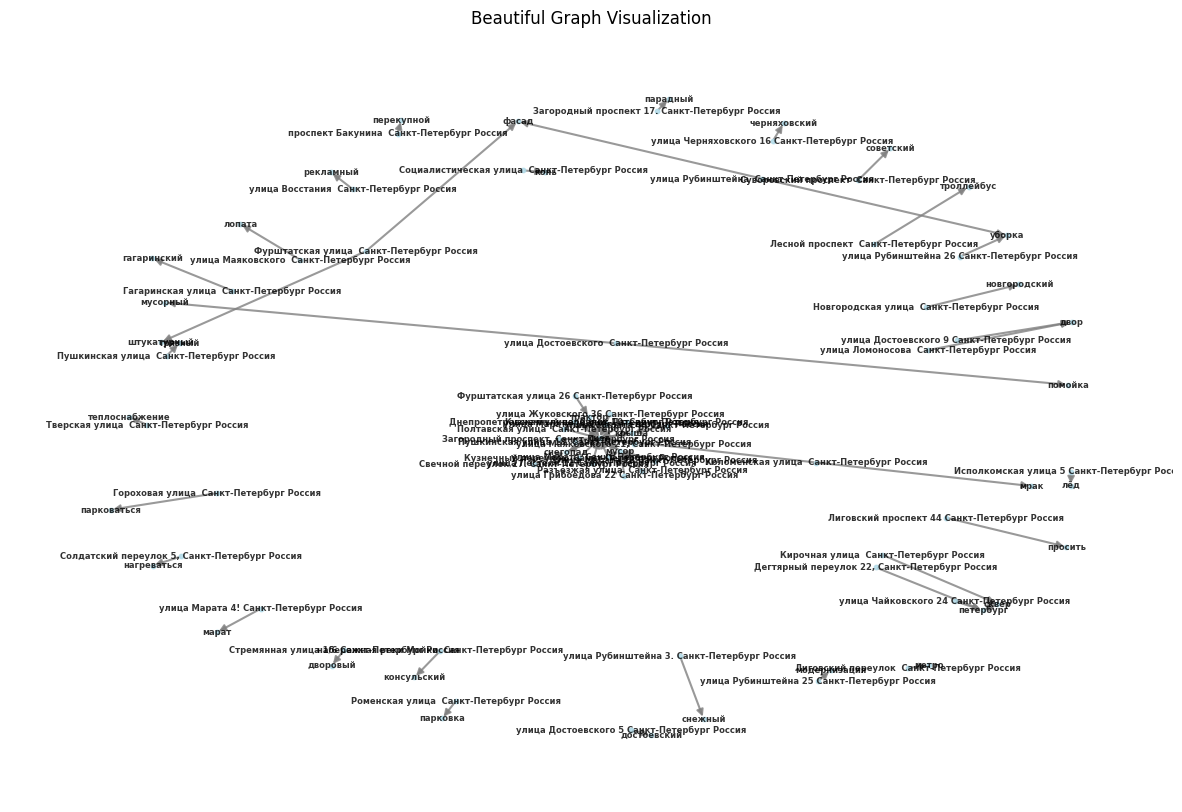

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(15, 10))

# Draw the graph with customizations
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
                node_size=10, font_size=6, font_weight='bold', width=1.5, alpha=0.8)

# Add a title to the graph
plt.title("Beautiful Graph Visualization")

# Customize the plot background color
plt.rcParams["axes.facecolor"] = "lightgray"

# Remove the axes
plt.axis('off')

# Show the graph
plt.show()

###### Сохранение полученного графа в формате ``graphml``

In [20]:
nx.write_graphml(G, "sample_data_graph.graphml", encoding = 'utf-8')